# Markov model

#In this paper, the observable variables I use are: the underlying asset returns, the Ted Spread, the 10 year - 2 year constant maturity spread, and the 10 year - 3 month constant maturity spread.

In [12]:
#http://www.blackarbs.com/blog/introduction-hidden-markov-models-python-networkx-sklearn/2/9/2017?fbclid=IwAR1SyGrft83RN6nCrYJvbCmolAeHF8VZjVP7WMnE6xHARTNJTSEKc_AazuI

In [5]:
import pandas as pd
import pandas_datareader.data as web
import sklearn.mixture as mix

import numpy as np
import scipy.stats as scs

import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt
from matplotlib.dates import YearLocator, MonthLocator
%matplotlib inline

import seaborn as sns
import missingno as msno
from tqdm import tqdm
p=print

C:\Users\HP\AppData\Local\Temp/ipykernel_6272/4128946114.py:8: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  end = pd.datetime.today()


            TEDRATE  T10Y2Y  T10Y3M        SPY      sret
2002-01-03     0.18    1.97    3.43  79.387589  0.011275
2002-01-04     0.18    1.99    3.46  79.917587  0.006654
2002-01-07     0.21    2.01    3.41  79.353622 -0.007082
2002-01-08     0.19    2.03    3.42  79.170174 -0.002314
2002-01-09     0.19    2.07    3.42  78.524681 -0.008187


<AxesSubplot:>

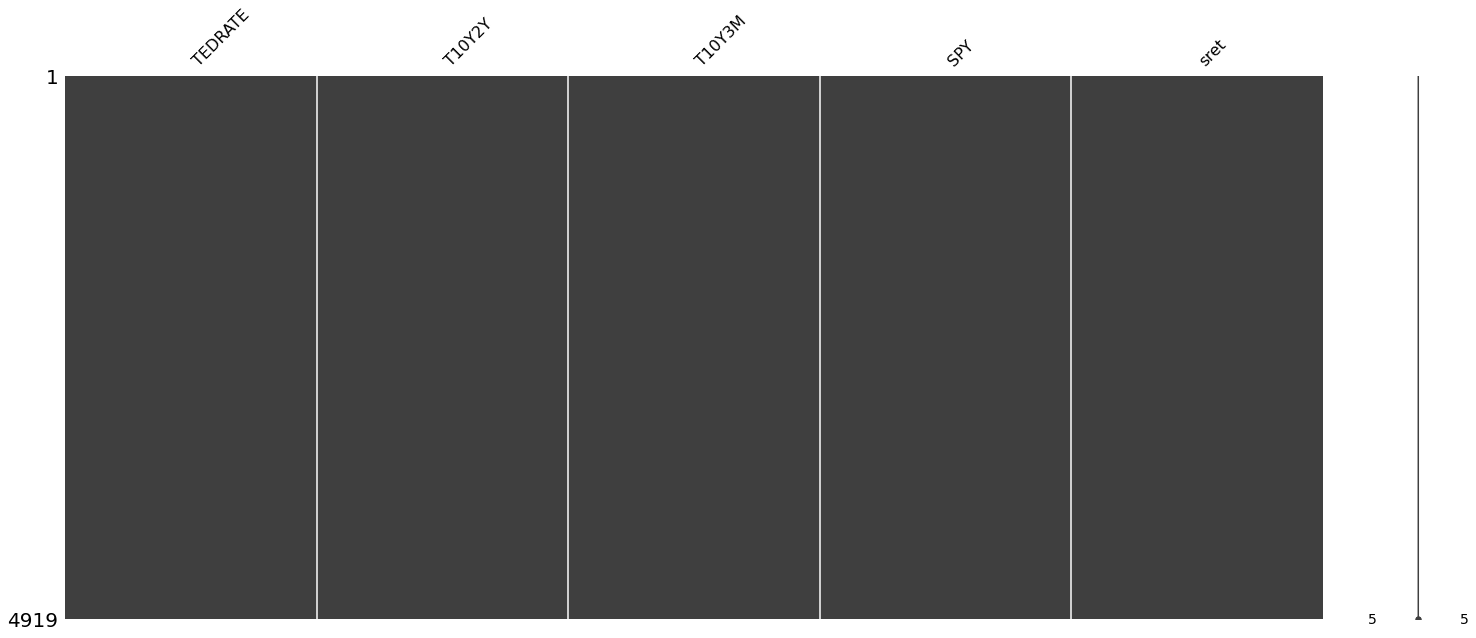

In [7]:
# get fed data

f1 = 'TEDRATE' # ted spread
f2 = 'T10Y2Y' # constant maturity ten yer - 2 year
f3 = 'T10Y3M' # constant maturity 10yr - 3m

start = pd.to_datetime('2002-01-01')
end = pd.datetime.today()

mkt = 'SPY'
MKT = (web.DataReader([mkt], 'yahoo', start, end)['Adj Close']
       .rename(columns={mkt:mkt})
       .assign(sret=lambda x: np.log(x[mkt]/x[mkt].shift(1)))
       .dropna())

data = (web.DataReader([f1, f2, f3], 'fred', start, end)
        .join(MKT, how='inner')
        .dropna()
       )

p(data.head())

# gives us a quick visual inspection of the data
msno.matrix(data)

Next we will use the sklearn's GaussianMixture to fit a model that estimates these regimes. We will explore mixture models  in more depth in part 2 of this series. The important takeaway is that mixture models implement a closely related unsupervised form of density estimation. It makes use of the expectation-maximization algorithm to estimate the means and covariances of the hidden states (regimes). For now, it is ok to think of it as a magic button for guessing the transition and emission probabilities, and most likely path. 

We have to specify the number of components for the mixture model to fit to the time series. In this example the components can be thought of as regimes. We will arbitrarily classify the regimes as High, Neutral and Low Volatility and set the number of components to three.

Means and vars of each hidden state
0th hidden state
mean =  [2.25086543e-01 2.04890896e+00 2.63007936e+00 4.37994419e-04]
var =  [3.91438511e-03 2.19060148e-01 4.02046533e-01 8.92091549e-05]

1th hidden state
mean =  [0.33979542 0.53638135 0.80381946 0.00095597]
var =  [2.27922160e-02 2.07413442e-01 5.13214844e-01 4.86792853e-05]

2th hidden state
mean =  [ 1.01493636  1.48071078  1.91291297 -0.0019215 ]
var =  [5.18046381e-01 4.24401712e-01 9.04472869e-01 5.58988846e-04]



findfont: Font family ['courier prime code'] not found. Falling back to DejaVu Sans.
findfont: Font family ['courier prime code'] not found. Falling back to DejaVu Sans.


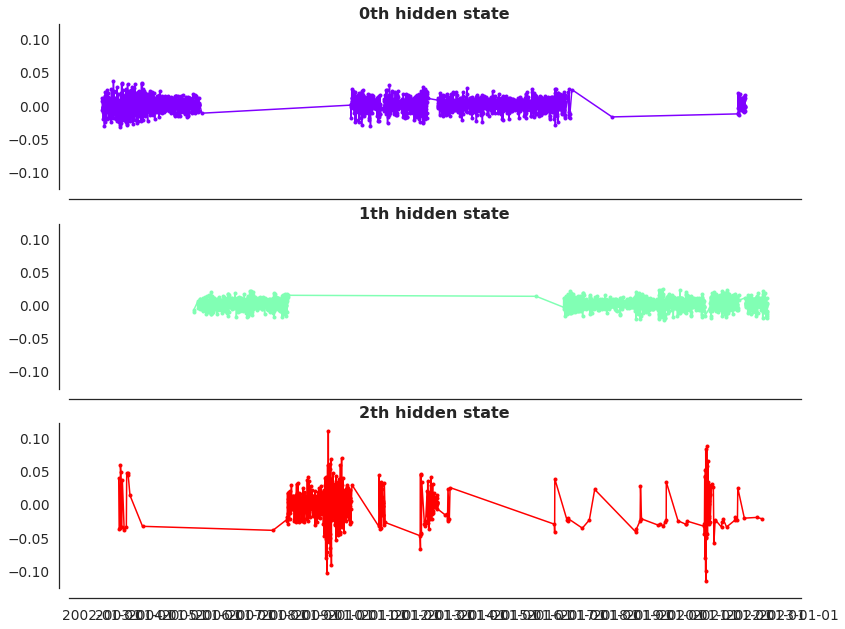

In [9]:
# code adapted from http://hmmlearn.readthedocs.io
# for sklearn 18.1

col = 'sret'
select = data.loc[:].dropna()

ft_cols = [f1, f2, f3, 'sret']
X = select[ft_cols].values

model = mix.GaussianMixture(n_components=3, 
                            covariance_type="full", 
                            n_init=100, 
                            random_state=7).fit(X)

# Predict the optimal sequence of internal hidden state
hidden_states = model.predict(X)

print("Means and vars of each hidden state")
for i in range(model.n_components):
    print("{0}th hidden state".format(i))
    print("mean = ", model.means_[i])
    print("var = ", np.diag(model.covariances_[i]))
    print()

sns.set(font_scale=1.25)
style_kwds = {'xtick.major.size': 3, 'ytick.major.size': 3,
              'font.family':u'courier prime code', 'legend.frameon': True}
sns.set_style('white', style_kwds)

fig, axs = plt.subplots(model.n_components, sharex=True, sharey=True, figsize=(12,9))
colors = cm.rainbow(np.linspace(0, 1, model.n_components))

for i, (ax, color) in enumerate(zip(axs, colors)):
    # Use fancy indexing to plot data in each state.
    mask = hidden_states == i
    ax.plot_date(select.index.values[mask],
                 select[col].values[mask],
                 ".-", c=color)
    ax.set_title("{0}th hidden state".format(i), fontsize=16, fontweight='demi')

    # Format the ticks.
    ax.xaxis.set_major_locator(YearLocator())
    ax.xaxis.set_minor_locator(MonthLocator())
    sns.despine(offset=10)

plt.tight_layout()
fig.savefig('Hidden Markov (Mixture) Model_Regime Subplots.png')

In the above image, I've highlighted each regime's daily expected mean and variance of SPY returns. It appears the 1th hidden state is our low volatility regime. Note that the 1th hidden state has the largest expected return and the smallest variance.The 0th hidden state is the neutral volatility regime with the second largest return and variance. Lastly the 2th hidden state is high volatility regime. We can see the expected return is negative and the variance is the largest of the group. 

C:\Users\HP\anaconda3\lib\site-packages\seaborn\axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
findfont: Font family ['courier prime code'] not found. Falling back to DejaVu Sans.


        Date  states  TEDRATE  T10Y2Y  T10Y3M        SPY      sret  mkt_cret
0 2002-01-03       0     0.18    1.97    3.43  79.387589  0.011275  0.011275
1 2002-01-04       0     0.18    1.99    3.46  79.917587  0.006654  0.017929
2 2002-01-07       0     0.21    2.01    3.41  79.353622 -0.007082  0.010847
3 2002-01-08       0     0.19    2.03    3.42  79.170174 -0.002314  0.008533
4 2002-01-09       0     0.19    2.07    3.42  78.524681 -0.008187  0.000346


findfont: Font family ['courier prime code'] not found. Falling back to DejaVu Sans.
findfont: Font family ['courier prime code'] not found. Falling back to DejaVu Sans.


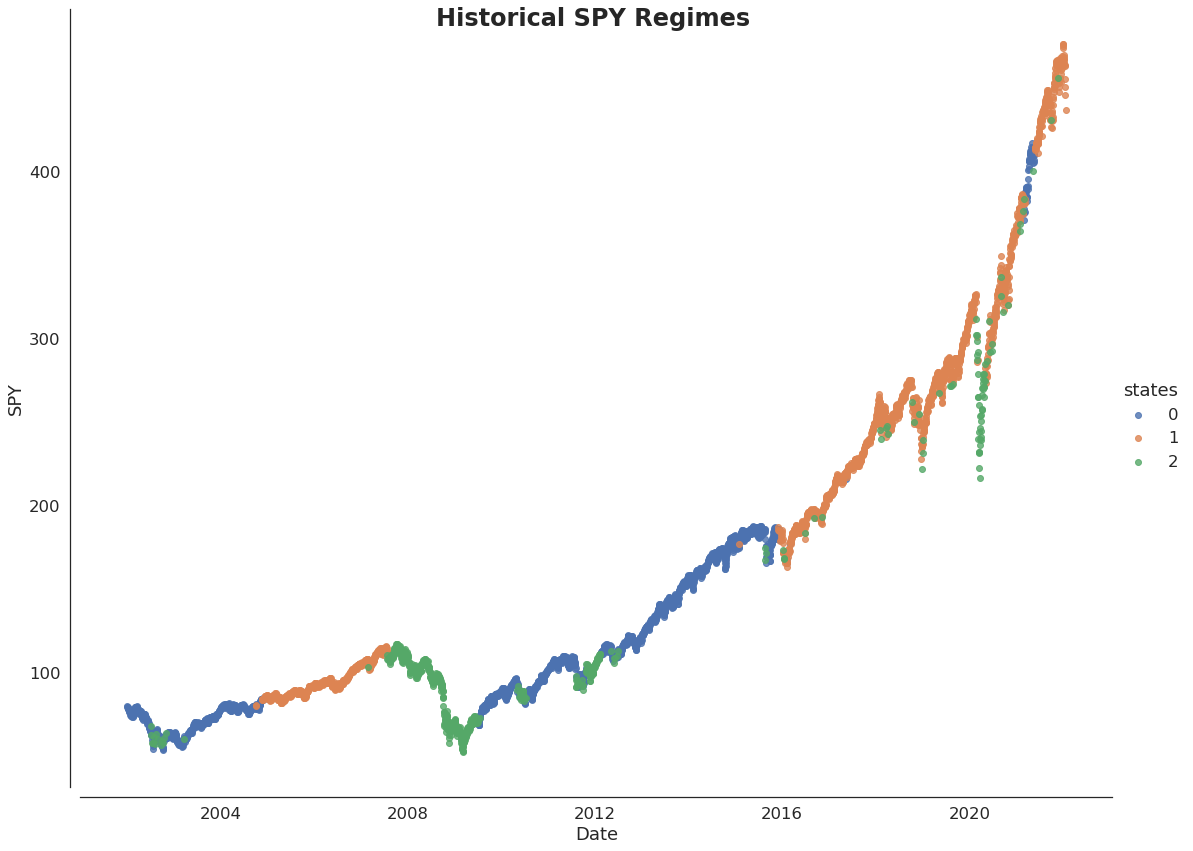

In [11]:
sns.set(font_scale=1.5)
states = (pd.DataFrame(hidden_states, columns=['states'], index=select.index)
          .join(select, how='inner')
          .assign(mkt_cret=select.sret.cumsum())
          .reset_index(drop=False)
          .rename(columns={'index':'Date'}))
p(states.head())

sns.set_style('white', style_kwds)
order = [0, 1, 2]
fg = sns.FacetGrid(data=states, hue='states', hue_order=order, aspect=1.31, size=12)
fg.map(plt.scatter, 'Date', mkt, alpha=0.8).add_legend()
sns.despine(offset=10)
fg.fig.suptitle('Historical SPY Regimes', fontsize=24, fontweight='demi')
fg.savefig('Hidden Markov (Mixture) Model_SPY Regimes.png')

Means and vars of each hidden state
0th hidden state
mean =  [2.25086543e-01 2.04890896e+00 2.63007936e+00 4.37994419e-04]
var =  [3.91438511e-03 2.19060148e-01 4.02046533e-01 8.92091549e-05]

1th hidden state
mean =  [0.33979542 0.53638135 0.80381946 0.00095597]
var =  [2.27922160e-02 2.07413442e-01 5.13214844e-01 4.86792853e-05]

2th hidden state
mean =  [ 1.01493636  1.48071078  1.91291297 -0.0019215 ]
var =  [5.18046381e-01 4.24401712e-01 9.04472869e-01 5.58988846e-04]



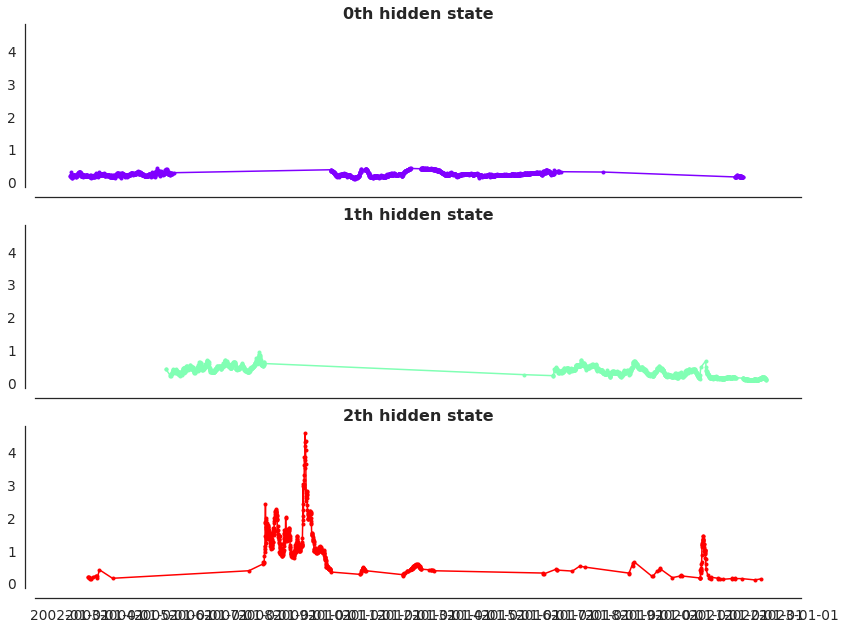

In [16]:
#TEDRATE  T10Y2Y  T10Y3M 
col = 'TEDRATE'
select = data.loc[:].dropna()

ft_cols = [f1, f2, f3, 'sret']
X = select[ft_cols].values

model = mix.GaussianMixture(n_components=3, 
                            covariance_type="full", 
                            n_init=100, 
                            random_state=7).fit(X)

# Predict the optimal sequence of internal hidden state
hidden_states = model.predict(X)

print("Means and vars of each hidden state")
for i in range(model.n_components):
    print("{0}th hidden state".format(i))
    print("mean = ", model.means_[i])
    print("var = ", np.diag(model.covariances_[i]))
    print()

sns.set(font_scale=1.25)
style_kwds = {'xtick.major.size': 3, 'ytick.major.size': 3,
              'font.family':u'courier prime code', 'legend.frameon': True}
sns.set_style('white', style_kwds)

fig, axs = plt.subplots(model.n_components, sharex=True, sharey=True, figsize=(12,9))
colors = cm.rainbow(np.linspace(0, 1, model.n_components))

for i, (ax, color) in enumerate(zip(axs, colors)):
    # Use fancy indexing to plot data in each state.
    mask = hidden_states == i
    ax.plot_date(select.index.values[mask],
                 select[col].values[mask],
                 ".-", c=color)
    ax.set_title("{0}th hidden state".format(i), fontsize=16, fontweight='demi')

    # Format the ticks.
    ax.xaxis.set_major_locator(YearLocator())
    ax.xaxis.set_minor_locator(MonthLocator())
    sns.despine(offset=10)

plt.tight_layout()
fig.savefig('Hidden Markov (Mixture) Model_Regime Subplots.png')

        Date  states  TEDRATE  T10Y2Y  T10Y3M        SPY      sret  mkt_cret
0 2002-01-03       0     0.18    1.97    3.43  79.387589  0.011275      0.18
1 2002-01-04       0     0.18    1.99    3.46  79.917587  0.006654      0.36
2 2002-01-07       0     0.21    2.01    3.41  79.353622 -0.007082      0.57
3 2002-01-08       0     0.19    2.03    3.42  79.170174 -0.002314      0.76
4 2002-01-09       0     0.19    2.07    3.42  78.524681 -0.008187      0.95


C:\Users\HP\anaconda3\lib\site-packages\seaborn\axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


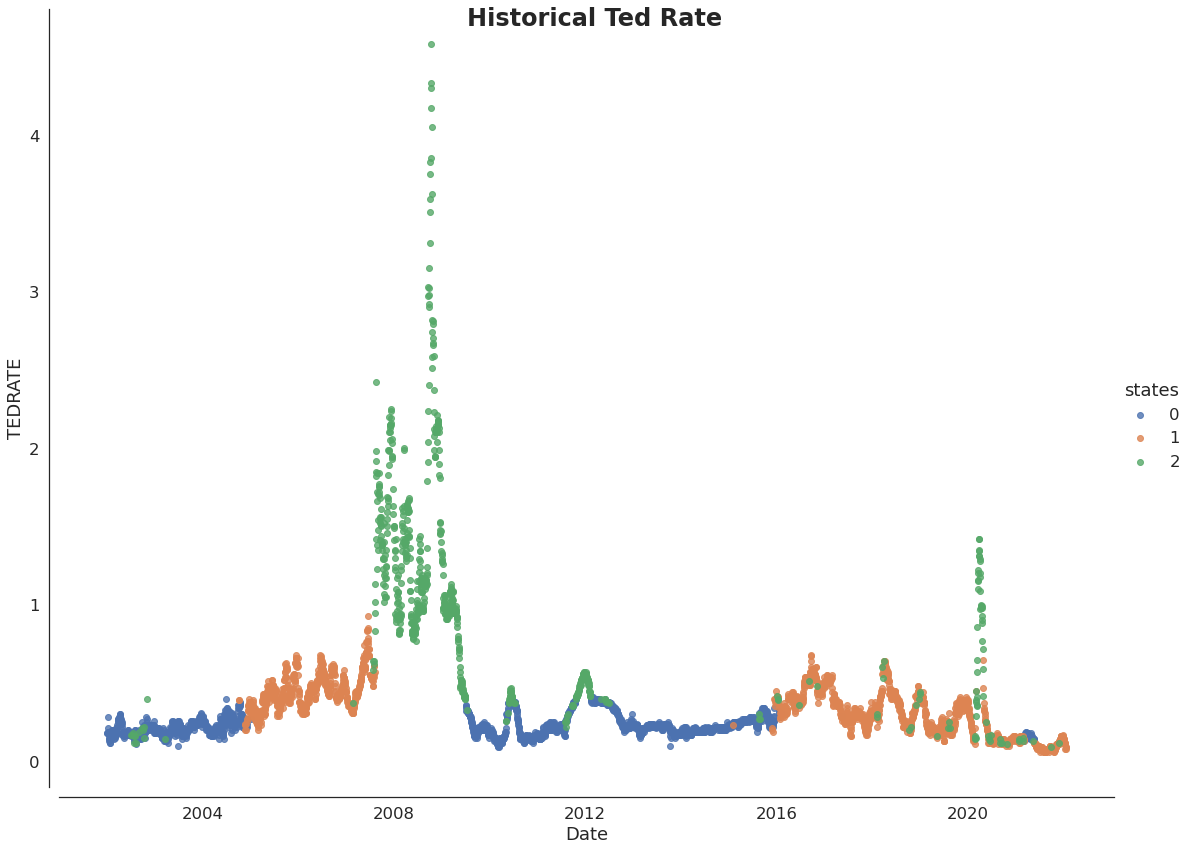

In [17]:
sns.set(font_scale=1.5)
states = (pd.DataFrame(hidden_states, columns=['states'], index=select.index)
          .join(select, how='inner')
          .assign(mkt_cret=select.TEDRATE.cumsum())
          .reset_index(drop=False)
          .rename(columns={'index':'Date'}))
p(states.head())

sns.set_style('white', style_kwds)
order = [0, 1, 2]
fg = sns.FacetGrid(data=states, hue='states', hue_order=order, aspect=1.31, size=12)
fg.map(plt.scatter, 'Date','TEDRATE', alpha=0.8).add_legend()
sns.despine(offset=10)
fg.fig.suptitle('Historical Ted Rate', fontsize=24, fontweight='demi')
fg.savefig('Ted Rate.png')

## Finding Equillibrium Matrix

In [24]:
start = pd.to_datetime('2002-01-01')
end = pd.datetime.today()

df = web.DataReader("SPY", 'yahoo', start, end)

C:\Users\HP\AppData\Local\Temp/ipykernel_6272/2789651500.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  end = pd.datetime.today()


In [25]:
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2002-01-02,115.750000,113.809998,115.110001,115.529999,18651900.0,78.497528
2002-01-03,116.949997,115.540001,115.650002,116.839996,15743000.0,79.387604
2002-01-04,117.980003,116.550003,117.169998,117.620003,20140700.0,79.917580
2002-01-07,117.989998,116.559998,117.699997,116.790001,13106500.0,79.353622
2002-01-08,117.059998,115.970001,116.790001,116.519997,12683700.0,79.170151
...,...,...,...,...,...,...
2022-04-21,450.010010,437.100006,448.540009,438.059998,85417300.0,438.059998
2022-04-22,438.079987,425.440002,436.910004,426.040009,132354400.0,426.040009
2022-04-25,428.690002,418.839996,423.670013,428.510010,119647700.0,428.510010


In [26]:
df["state"]=df["Close"].astype(float).pct_change()
df['state']=df['state'].apply(lambda x: 'Upside' if (x > 0.001) else ('Downside' if (x<=0.001) else 'Consolidation'))

df['priorstate']=df['state'].shift(1)

states = df [['priorstate','state']].dropna()
states_matrix = states.groupby(['priorstate','state']).size().unstack().fillna(0)

transition_matrix= states_matrix.apply(lambda x: x/float(x.sum()),axis=1)
print(transition_matrix)

state          Downside    Upside
priorstate                       
Consolidation  0.000000  1.000000
Downside       0.497570  0.502430
Upside         0.551046  0.448954


## Forecasting Futures Probabilities of States using Python
Let’s consider time as t. Now, We will see observe other probability matrices.“Transition Matrix” is the probability matrix at t=0. It shows the probability at t=0. However, we will build the Markov Chain by multiplying this transition matrix by itself to obtain the probability matrix in t=1 which would allow us to make one-day forecasts

In [27]:
df["state"]=df["Close"].astype(float).pct_change()
df['state']=df['state'].apply(lambda x: 'Upside' if (x > 0) else 'Downside' )

df['priorstate']=df['state'].shift(1)

states = df [['priorstate','state']].dropna()
states_matrix = states.groupby(['priorstate','state']).size().unstack().fillna(0)

transition_matrix= states_matrix.apply(lambda x: x/float(x.sum()),axis=1)
print(transition_matrix)

state       Downside    Upside
priorstate                    
Downside    0.436910  0.563090
Upside      0.470736  0.529264


In [28]:
t_0 = transition_matrix.copy()
t_1 =t_0.dot(t_0)
t_1

state,Downside,Upside
priorstate,,
Downside,0.455957,0.544043
Upside,0.454813,0.545187


Now, We need to extend the Markov Chain similarly.If we continue multiplying the transition matrix that we have obtained in t=1 by the original transition matrix in t0, we obtain the probabilities in time t=2. Let’s find the transition matrix at t=2 and t=3 and so on in a similar manner.

In [29]:
t_2 = t_0.dot(t_1)
t_2

state,Downside,Upside
priorstate,,
Downside,0.455313,0.544687
Upside,0.455351,0.544649


## Equilibrium Matrix using Python

In [30]:
## Equilibrium Matrix using Python

t_0 = transition_matrix.copy()

t_m = t_0.copy()
t_n = t_0.dot(t_0)

i = 1
while(not(t_m.equals(t_n))):
    i += 1
    t_m = t_n.copy()
    t_n = t_n.dot(t_0)

print("Equilibrium Matrix Number: " + str(i))
print(t_n)

Equilibrium Matrix Number: 12
state       Downside    Upside
priorstate                    
Downside    0.455334  0.544666
Upside      0.455334  0.544666


The equilibrium Matrix is a stationary state. So, As per the theory of the Markov Chain, This figure will stay the same for foreseeable data points

In [32]:
import datetime

In [34]:
##Random Walk

symbol = "SPY"
days = 9209
end_date = datetime.datetime.now().strftime("%d-%b-%Y")
end_date = str(end_date)

start_date = (datetime.datetime.now()- datetime.timedelta(days=days)).strftime("%d-%b-%Y")
start_date = str(start_date)

#df=index_history("SPY",start_date,end_date)
df = web.DataReader("SPY", 'yahoo', start_date, end_date)

df["state"]=df["Close"].astype(float).pct_change()
df['state']=df['state'].apply(lambda x: 'Upside' if (x > 0) else 'Downside' )

df['priorstate']=df['state'].shift(1)

states = df [['priorstate','state']].dropna()
states_matrix = states.groupby(['priorstate','state']).size().unstack().fillna(0)

transition_matrix= states_matrix.apply(lambda x: x/float(x.sum()),axis=1)
t_0 = transition_matrix.copy()

t_m = t_0.copy()
t_n = t_0.dot(t_0)

i = 1
while(not(t_m.equals(t_n))):
    i += 1
    t_m = t_n.copy()
    t_n = t_n.dot(t_0)

print("Equilibrium Matrix Number: " + str(i))
print(t_n)

Equilibrium Matrix Number: 11
state       Downside    Upside
priorstate                    
Downside    0.462416  0.537584
Upside      0.462416  0.537584


So, t = 11, We get our equilibrium matrix.

Anyways, the number of the matrix where we get the equilibrium does not matter much. What matters is the values. We can see the values are really close!

Interpreting,

P(priorstate="Downside"/state="Downside) i.e. If We had a Downside day today, Tomorrow there is 53.7584% probability of having a Downside day.

Similarly,

If We had a Downside day today, Tomorrow there is 46% probability of having an Upside day.